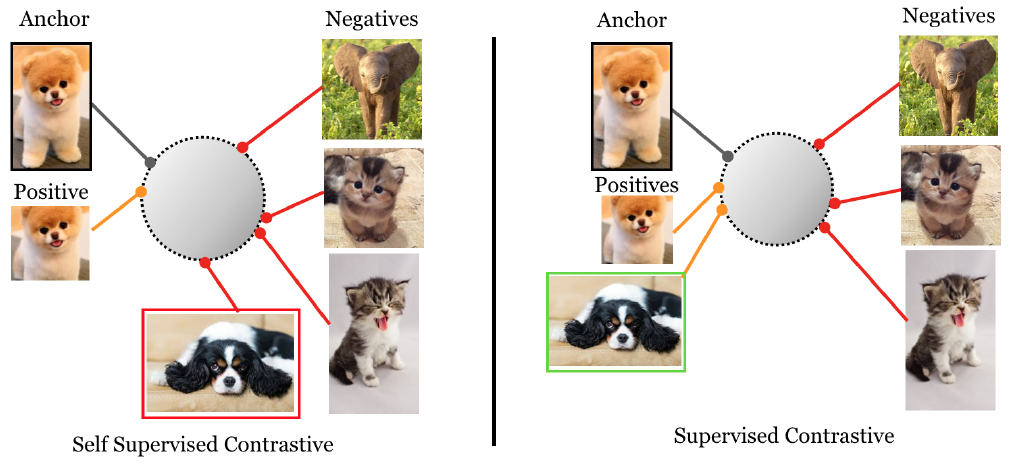

In [1]:
from IPython.display import Image
Image('./supcon.png')

# 필요한 패키지 불러오기

In [2]:
import os
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models

from torch.utils.data import Dataset
from torchvision.transforms import transforms
from torchvision import transforms, datasets

import warnings
warnings.filterwarnings(action='ignore')

# 학습에 필요한 하이퍼파라미터 정의

In [18]:
ARCHITECTURE = 'resnet18'
MLP_HIDDEN_SIZE = 512
PROJECTION_SIZE = 128
NUM_WORKER = 0
N_VIEWS = 2
EPOCHS = 5
BATCH_SIZE = 256
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
SEED = 123
NUM_CLASS = 10
LOG_EVERY_N_STEPS = 20
TEMPERATURE = 0.1
BASE_TEMPERATURE = 0.1
GPU_INDEX = 0
DEVICE = 'cuda'

# CIFAR10 Dataset 정의

In [9]:
class CIFAR10Dataset(Dataset):
    def __init__(self, 
                 data_dir: str = './data',
                 mode: str = 'train'):
        
        self.data_dir = data_dir
        self.mode = mode
        
        # 저장 경로 폴더 없을 때 만들기
        os.makedirs(data_dir, exist_ok=True)
    
    @staticmethod
    def get_transform(size: int = None,
                      s: int = 1):
        """
        Return a set of data augmentation transformations 
        as described in the SimCLR paper.
        """
        
        normalize = transforms.Normalize(
            mean=(0.4914, 0.4822, 0.4465),
            std=(0.2023, 0.1994, 0.2010))
        color_jitter = transforms.ColorJitter(0.8 * s, 
                                              0.8 * s,
                                              0.8 * s,
                                              0.2 * s)
        data_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            GaussianBlur(kernel_size=int(0.1 * size)),
            transforms.ToTensor(),
            normalize,
        ])
        
        return data_transforms
    
    # For SupCon
    def get_pretrain_dataset(self, n_views: int = 2):        
        # SupCon, 지도 학습에 사용되는 학습 데이터
        
        if self.mode == 'train':
            train_dataset = datasets.CIFAR10(self.data_dir,
                                             train=True,
                                             transform=ViewGenerator(
                                                 base_transform=self.get_transform(size=32),
                                                 n_views=n_views),
                                             download=True)
            
            return train_dataset
        
        else:
            raise NotImplementedError()
    
    # For Supervised Setting (Transfer Learning)
    def get_dataset(self):        
        # SupCon, 지도 학습에 사용되는 학습 데이터
        
        if self.mode == 'train':
            train_dataset = datasets.CIFAR10(self.data_dir,
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)
            
            return train_dataset
        
        elif self.mode == 'test':
            # 지도 학습 테스트에 사용되는 테스트 데이터
            test_dataset = datasets.CIFAR10(self.data_dir,
                                            train=False,
                                            transform=transforms.ToTensor(),
                                            download=False)
            
            return test_dataset
        
        else:
            raise NotImplementedError()
            

class GaussianBlur(object):
    """
    blur a single image on CPU
    """
    def __init__(self, kernel_size: int = None):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        self.blur_h = nn.Conv2d(in_channels=3,
                                out_channels=3,
                                kernel_size=(kernel_size, 1),
                                stride=1,
                                padding=0, 
                                bias=False,
                                groups=3)
        self.blur_v = nn.Conv2d(in_channels=3,
                                out_channels=3,
                                kernel_size=(1, kernel_size),
                                stride=1,
                                padding=0, 
                                bias=False,
                                groups=3)
        self.k = kernel_size
        self.r = radias
        
        self.blur = nn.Sequential(
            nn.ReflectionPad2d(radias),
            self.blur_h,
            self.blur_v
        )
        
        self.pil_to_tensor = transforms.ToTensor()
        self.tensor_to_pil = transforms.ToPILImage()
    
    def __call__(self, img):
        img = self.pil_to_tensor(img).unsqueeze(0)
        
        sigma = np.random.uniform(0.1, 2.0)
        x = np.arange(-self.r, self.r + 1)
        x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
        x = x / x.sum()
        x = torch.from_numpy(x).view(1, -1).repeat(3, 1)
        
        self.blur_h.weight.data.copy_(x.view(3, 1, self.k, 1))
        self.blur_v.weight.data.copy_(x.view(3, 1, 1, self.k))
    
        with torch.no_grad():
            img = self.blur(img)
            img = img.squeeze()
        
        img = self.tensor_to_pil(img)
        
        return img
    
    
class ViewGenerator(object):
    """
    Take two random crops of one image as the query and key.
    """
    
    def __init__(self,
                 base_transform,
                 n_views: int = 2):
        
        self.base_transform = base_transform
        self.n_views = n_views
    
    def __call__(self, x):
        
        return [self.base_transform(x) for i in range(self.n_views)]

# 학습 네트워크 정의

In [19]:
class ResNet(nn.Module):
    def __init__(self, base_model: str = None):
        super(ResNet, self).__init__()
        
        self.resnet_dict = {
            'resnet18': models.resnet18(pretrained=False),
            'resnet50': models.resnet50(pretrained=False)
        }
        
        resnet = self.get_basemodel(base_model)
        
        # Define CNN encoder
        self.encoder = nn.Sequential(
            *list(resnet.children())[:-1])
        
        # Define MLP Projection
        self.projection = MLPHead(in_channels=resnet.fc.in_features,
                                  mlp_hidden_size=MLP_HIDDEN_SIZE,
                                  projection_size=PROJECTION_SIZE)
    
    def forward(self, x: torch.Tensor):
        h = self.encoder(x)
        h = h.view(h.shape[0], h.shape[1])
        
        return self.projection(h)
    
    def get_basemodel(self, model_name: str = None):
 
        model = self.resnet_dict[model_name]

        return model
    

class MLPHead(nn.Module):
    def __init__(self, 
                 in_channels: int,
                 mlp_hidden_size: int,
                 projection_size):
        super(MLPHead, self).__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, mlp_hidden_size), 
            nn.ReLU(inplace=True),
            nn.Linear(mlp_hidden_size, projection_size)
        )
    
    def forward(self, x):
        
        return self.mlp(x)

# 평가 지표 및 SupCon 학습 정의

In [20]:
def accuracy(output: torch.FloatTensor, 
             target: torch.LongTensor, 
             topk: tuple = (1, )):
    """
    Computes the accuracy over the k top predictions
    for the specified values of k.
    """
    
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        
        return res
    
    
class SupCon(object):
    def __init__(self, **kwargs):
        self.model = kwargs['model'].to(DEVICE)
        self.optimizer = kwargs['optimizer']
        self.scheduler = kwargs['scheduler']
    
    def supconloss(self, 
                   features: torch.FloatTensor,
                   n_views: int = 2,
                   labels: torch.LongTensor = None,
                   mask: torch.Tensor = None):
        """
        Compute loss for model.
        If both 'labels' and 'mask' are None,
        it degenerates to SimCLR unsupervised loss
        : https://arxiv.org/pdf/2002.05709.pdf
        
        Args:
            features: hidden vector of shape [batch_size * n_views, ...].
            n_views: 2.
            labels: ground Truth of shape [batch_size].
            mask: contrastive mask of shape [batch_size, batch_size], mask_{i, j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """        
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both labels and mask.')

        elif labels is None and mask is None:
            mask = torch.eye(BATCH_SIZE, dtype=torch.float32).to(DEVICE)

        elif labels is not None:
            # Define appropriate labels for n_views
            labels = torch.cat([labels, labels], dim=0)

            labels = labels.contiguous().view(-1, 1)  # 연산 시 메모리 할당 개념

            if labels.shape[0] != len(labels):
                raise ValueError('Number of labels does not match number of features.')

            mask = torch.eq(labels, labels.T).float().to(DEVICE)

        else:
            mask = mask.float().to(DEVICE)

        # Mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            dim=1,
            index=torch.arange(len(labels)).view(-1, 1).to(device=DEVICE),
            value=0)

        # Define mask based on same action labels except self-contrast cases
        mask = mask * logits_mask

        # Normalize feature vector
        features = F.normalize(features, dim=1)

        # Compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(features, features.T),  # Anchor dot Contrast
            TEMPERATURE)

        # For numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # Compute log probability
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # Compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # Supervised Contrastive Loss (SCL)
        loss = - (TEMPERATURE / BASE_TEMPERATURE) * mean_log_prob_pos
        loss = loss.view(n_views, int(len(labels) / 2)).mean()

        return loss
    
    def train(self, train_loader):
        
        n_iter = 0
        for epoch in range(EPOCHS):
            
            train_loss = 0
            for images, labels in tqdm(train_loader):
                images = torch.cat(images, dim=0)  # 2 * Batch Size
                images = images.to(DEVICE)
                
                labels = labels.to(DEVICE)
                
                features = self.model(images)
                loss = self.supconloss(features=features, labels=labels)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss
                
                if n_iter % LOG_EVERY_N_STEPS == 0:
                    print(f'Loss: {loss} \n'
                          f'Learning Rate: {self.scheduler.get_lr()[0]}')
                
                n_iter += 1
            
            train_loss /= (len(train_loader))
            
            # Warmup for the first 10 epochs
            if epoch >= 10:
                self.scheduler.step()
                
            print('=' * 30)
            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {train_loss} \n'
                  f'Learning Rate: {self.scheduler.get_lr()[0]}')
            
        return self.model   

# SupCon 코드 실행

In [21]:
def main():
    
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    
    # Define Dataset, Dataloader
    dataset = CIFAR10Dataset(mode='train')
    
    train_dataset = dataset.get_pretrain_dataset(n_views=N_VIEWS)
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKER,
        drop_last=True)
    
    # Define Model, optimizer, scheduler
    model = ResNet(
        base_model=ARCHITECTURE)
    
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=LEARNING_RATE, 
        weight_decay=WEIGHT_DECAY)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer=optimizer,
        T_max=len(train_loader),
        eta_min=0,
        last_epoch=-1)
    
    with torch.cuda.device(GPU_INDEX):
        supcon = SupCon(
            model=model,
            optimizer=optimizer,
            scheduler=scheduler)
        
        pretrained_model = supcon.train(train_loader=train_loader)
    
    return pretrained_model


if __name__ == '__main__':
    pretrained_model = main()

Files already downloaded and verified


  1%|▍                                                                                 | 1/195 [00:00<02:55,  1.10it/s]

Loss: 6.458047866821289 
Learning Rate: 0.0003


 11%|████████▋                                                                        | 21/195 [00:17<02:23,  1.21it/s]

Loss: 6.209596633911133 
Learning Rate: 0.0003


 21%|█████████████████                                                                | 41/195 [00:33<02:06,  1.22it/s]

Loss: 6.191860198974609 
Learning Rate: 0.0003


 31%|█████████████████████████▎                                                       | 61/195 [00:49<01:48,  1.23it/s]

Loss: 6.197443008422852 
Learning Rate: 0.0003


 42%|█████████████████████████████████▋                                               | 81/195 [01:05<01:30,  1.26it/s]

Loss: 6.177934646606445 
Learning Rate: 0.0003


 52%|█████████████████████████████████████████▍                                      | 101/195 [01:21<01:14,  1.26it/s]

Loss: 6.158689498901367 
Learning Rate: 0.0003


 62%|█████████████████████████████████████████████████▋                              | 121/195 [01:37<01:00,  1.23it/s]

Loss: 6.185725212097168 
Learning Rate: 0.0003


 72%|█████████████████████████████████████████████████████████▊                      | 141/195 [01:53<00:43,  1.24it/s]

Loss: 6.120665073394775 
Learning Rate: 0.0003


 83%|██████████████████████████████████████████████████████████████████              | 161/195 [02:09<00:26,  1.26it/s]

Loss: 6.1163330078125 
Learning Rate: 0.0003


 93%|██████████████████████████████████████████████████████████████████████████▎     | 181/195 [02:23<00:10,  1.29it/s]

Loss: 6.108109474182129 
Learning Rate: 0.0003


  0%|                                                                                          | 0/195 [00:00<?, ?it/s]

Epoch: 1 
Loss: 6.165562629699707 
Learning Rate: 0.0003


  3%|██▌                                                                               | 6/195 [00:04<02:33,  1.23it/s]

Loss: 6.160083293914795 
Learning Rate: 0.0003


 13%|██████████▊                                                                      | 26/195 [00:20<02:13,  1.26it/s]

Loss: 6.103274345397949 
Learning Rate: 0.0003


 24%|███████████████████                                                              | 46/195 [00:36<01:58,  1.26it/s]

Loss: 6.14961576461792 
Learning Rate: 0.0003


 34%|███████████████████████████▍                                                     | 66/195 [00:52<01:39,  1.29it/s]

Loss: 6.095982551574707 
Learning Rate: 0.0003


 44%|███████████████████████████████████▋                                             | 86/195 [01:07<01:21,  1.33it/s]

Loss: 6.095218181610107 
Learning Rate: 0.0003


 54%|███████████████████████████████████████████▍                                    | 106/195 [01:22<01:08,  1.31it/s]

Loss: 6.088993072509766 
Learning Rate: 0.0003


 65%|███████████████████████████████████████████████████▋                            | 126/195 [01:37<00:52,  1.30it/s]

Loss: 6.089559078216553 
Learning Rate: 0.0003


 75%|███████████████████████████████████████████████████████████▉                    | 146/195 [01:52<00:37,  1.32it/s]

Loss: 6.09589147567749 
Learning Rate: 0.0003


 85%|████████████████████████████████████████████████████████████████████            | 166/195 [02:08<00:23,  1.23it/s]

Loss: 6.088157653808594 
Learning Rate: 0.0003


 95%|████████████████████████████████████████████████████████████████████████████▎   | 186/195 [02:24<00:07,  1.23it/s]

Loss: 6.153104305267334 
Learning Rate: 0.0003


  0%|                                                                                          | 0/195 [00:00<?, ?it/s]

Epoch: 2 
Loss: 6.117419242858887 
Learning Rate: 0.0003


  6%|████▌                                                                            | 11/195 [00:08<02:28,  1.24it/s]

Loss: 6.072750568389893 
Learning Rate: 0.0003


 16%|████████████▉                                                                    | 31/195 [00:24<02:04,  1.32it/s]

Loss: 6.087375164031982 
Learning Rate: 0.0003


 26%|█████████████████████▏                                                           | 51/195 [00:39<01:47,  1.34it/s]

Loss: 6.10154390335083 
Learning Rate: 0.0003


 36%|█████████████████████████████▍                                                   | 71/195 [00:54<01:34,  1.32it/s]

Loss: 6.054243564605713 
Learning Rate: 0.0003


 47%|█████████████████████████████████████▊                                           | 91/195 [01:09<01:19,  1.30it/s]

Loss: 6.059515476226807 
Learning Rate: 0.0003


 57%|█████████████████████████████████████████████▌                                  | 111/195 [01:24<01:06,  1.26it/s]

Loss: 6.062896728515625 
Learning Rate: 0.0003


 67%|█████████████████████████████████████████████████████▋                          | 131/195 [01:40<00:51,  1.24it/s]

Loss: 6.082258224487305 
Learning Rate: 0.0003


 77%|█████████████████████████████████████████████████████████████▉                  | 151/195 [01:56<00:35,  1.24it/s]

Loss: 6.0942230224609375 
Learning Rate: 0.0003


 88%|██████████████████████████████████████████████████████████████████████▏         | 171/195 [02:12<00:18,  1.26it/s]

Loss: 6.097063064575195 
Learning Rate: 0.0003


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 191/195 [02:27<00:03,  1.32it/s]

Loss: 6.074771881103516 
Learning Rate: 0.0003


  0%|                                                                                          | 0/195 [00:00<?, ?it/s]

Epoch: 3 
Loss: 6.090153694152832 
Learning Rate: 0.0003


  8%|██████▋                                                                          | 16/195 [00:12<02:17,  1.30it/s]

Loss: 6.045870780944824 
Learning Rate: 0.0003


 18%|██████████████▉                                                                  | 36/195 [00:27<02:08,  1.24it/s]

Loss: 6.0400390625 
Learning Rate: 0.0003


 29%|███████████████████████▎                                                         | 56/195 [00:43<01:44,  1.33it/s]

Loss: 6.097204685211182 
Learning Rate: 0.0003


 39%|███████████████████████████████▌                                                 | 76/195 [00:58<01:33,  1.27it/s]

Loss: 6.053092002868652 
Learning Rate: 0.0003


 49%|███████████████████████████████████████▉                                         | 96/195 [01:14<01:19,  1.24it/s]

Loss: 6.0250043869018555 
Learning Rate: 0.0003


 59%|███████████████████████████████████████████████▌                                | 116/195 [01:30<01:03,  1.24it/s]

Loss: 6.010800361633301 
Learning Rate: 0.0003


 70%|███████████████████████████████████████████████████████▊                        | 136/195 [01:46<00:46,  1.26it/s]

Loss: 6.04189920425415 
Learning Rate: 0.0003


 80%|████████████████████████████████████████████████████████████████                | 156/195 [02:01<00:29,  1.30it/s]

Loss: 6.065183639526367 
Learning Rate: 0.0003


 90%|████████████████████████████████████████████████████████████████████████▏       | 176/195 [02:16<00:14,  1.29it/s]

Loss: 6.061293601989746 
Learning Rate: 0.0003


  0%|                                                                                          | 0/195 [00:00<?, ?it/s]

Epoch: 4 
Loss: 6.065756797790527 
Learning Rate: 0.0003


  1%|▍                                                                                 | 1/195 [00:00<02:35,  1.25it/s]

Loss: 6.05171012878418 
Learning Rate: 0.0003


 11%|████████▋                                                                        | 21/195 [00:15<01:56,  1.49it/s]

Loss: 5.994256496429443 
Learning Rate: 0.0003


 21%|█████████████████                                                                | 41/195 [00:28<01:52,  1.37it/s]

Loss: 6.02752161026001 
Learning Rate: 0.0003


 31%|█████████████████████████▎                                                       | 61/195 [00:42<01:31,  1.46it/s]

Loss: 5.993871688842773 
Learning Rate: 0.0003


 42%|█████████████████████████████████▋                                               | 81/195 [00:56<01:46,  1.07it/s]

Loss: 6.016866683959961 
Learning Rate: 0.0003


 52%|█████████████████████████████████████████▍                                      | 101/195 [01:12<01:14,  1.26it/s]

Loss: 6.041464328765869 
Learning Rate: 0.0003


 62%|█████████████████████████████████████████████████▋                              | 121/195 [01:27<00:54,  1.35it/s]

Loss: 6.03626823425293 
Learning Rate: 0.0003


 72%|█████████████████████████████████████████████████████████▊                      | 141/195 [01:42<00:41,  1.30it/s]

Loss: 6.005303382873535 
Learning Rate: 0.0003


 83%|██████████████████████████████████████████████████████████████████              | 161/195 [01:57<00:26,  1.30it/s]

Loss: 6.110664367675781 
Learning Rate: 0.0003


 93%|██████████████████████████████████████████████████████████████████████████▎     | 181/195 [02:12<00:10,  1.34it/s]

Loss: 6.003594398498535 
Learning Rate: 0.0003


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [02:23<00:00,  1.36it/s]

Epoch: 5 
Loss: 6.039556503295898 
Learning Rate: 0.0003


# SupCon으로 사전 학습한 인코더를 사용하여 지도 학습 수행

In [22]:
class Supervised(object):
    def __init__(self, **kwargs):
        self.encoder = kwargs['encoder'].to(DEVICE)
        self.classifier = kwargs['classifier'].to(DEVICE)
        self.optimizer = kwargs['optimizer']
        self.criterion = nn.CrossEntropyLoss().to(DEVICE)

    def train_test(self, train_loader, test_loader):
        
        for epoch in range(EPOCHS):
            
            # Train
            top1_train_acc, train_loss = 0, 0
            for i, (images, targets) in enumerate(train_loader):
                images = images.to(DEVICE)
                targets = targets.to(DEVICE)
                
                # Freeze Encoder Parameters
                with torch.no_grad():
                    logits = self.encoder(images)
                    logits = logits.squeeze()
                
                logits = self.classifier(logits)
                loss = self.criterion(logits, targets)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                top1 = accuracy(logits, targets, topk=(1, ))
                top1_train_acc += top1[0]
                
                train_loss += loss
            
            top1_train_acc /= (i + 1)
            train_loss /= (i + 1)
            
            # Test
            top1_test_acc = 0
            top5_test_acc = 0
            for i, (images, targets) in enumerate(test_loader):
                images = images.to(DEVICE)
                targets = targets.to(DEVICE)
                
                with torch.no_grad():
                    logits = self.encoder(images)
                    logits = logits.squeeze()
                    logits = self.classifier(logits)
                
                top1, top5 = accuracy(logits, targets, topk=(1, 5))
                top1_test_acc += top1[0]
                top5_test_acc += top5[0]
            
            top1_test_acc /= (i + 1)
            top5_test_acc /= (i + 1)

            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {train_loss} \n'
                  f'Top1 Train Accuracy: {top1_train_acc.item()} \n'
                  f'Top1 Test Accuracy: {top1_test_acc.item()} \n'
                  f'Top5 Test Accuracy: {top5_test_acc.item()} \n')
            
        return self.encoder, self.classifier

# 지도 학습 실행

In [23]:
def main():
    
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
        
    # Define Dataset, Dataloader
    train_dataset = CIFAR10Dataset(mode='train')
    test_dataset = CIFAR10Dataset(mode='test')
    
    train_dataset = train_dataset.get_dataset()
    test_dataset = test_dataset.get_dataset()
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKER,
        drop_last=False)
    
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKER,
        drop_last=False)
    
    # Define encoder, optimizer, linear classifier
    encoder = pretrained_model.encoder
    
    classifier = nn.Linear(512, NUM_CLASS)

    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=LEARNING_RATE, 
        weight_decay=WEIGHT_DECAY)
    
    with torch.cuda.device(GPU_INDEX):
        supervised = Supervised(
            encoder=encoder,
            classifier=classifier,
            optimizer=optimizer)
        
        supervised_encoder, supervised_classifier = supervised.train_test(train_loader=train_loader,
                                                                          test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier


if __name__ == '__main__':
    supervised_model = main()

Files already downloaded and verified
Epoch: 1 
Loss: 1.4713252782821655 
Top1 Train Accuracy: 46.700016021728516 
Top1 Test Accuracy: 48.896484375 
Top5 Test Accuracy: 93.41796875 

Epoch: 2 
Loss: 1.3411331176757812 
Top1 Train Accuracy: 50.834659576416016 
Top1 Test Accuracy: 50.625 
Top5 Test Accuracy: 93.671875 

Epoch: 3 
Loss: 1.3158695697784424 
Top1 Train Accuracy: 51.7713623046875 
Top1 Test Accuracy: 50.95703125 
Top5 Test Accuracy: 93.984375 

Epoch: 4 
Loss: 1.300522804260254 
Top1 Train Accuracy: 52.32102966308594 
Top1 Test Accuracy: 51.806640625 
Top5 Test Accuracy: 94.248046875 

Epoch: 5 
Loss: 1.290324330329895 
Top1 Train Accuracy: 52.63911056518555 
Top1 Test Accuracy: 51.962890625 
Top5 Test Accuracy: 94.208984375 

